<h1>Continuum subtraction - MaNGA cube</h1>

Example of use of slicing, multi-dimension arithmetic, and smoothing.

In [1]:
# All imports used in this script
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from __future__ import print_function

import numpy.ma as ma
from scipy.ndimage import gaussian_filter
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline, InterpolatedUnivariateSpline, interp1d, PiecewisePolynomial

from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

# not using these, but import just to show what is available.
from astropy.convolution import Box2DKernel, MexicanHat2DKernel, Ring2DKernel,TrapezoidDisk2DKernel

%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 10

<h3>1 - Get raw data cube</h3>

Read cube from FITS file.

Ensure all NaN-valued pixels are zeroed before proceeding.

In [2]:
cube = fits.getdata('./data/manga-7443-12703-LOGCUBE.fits')
print(cube.shape)
cube[np.where(np.isnan(cube))] = 0.

(4563, 74, 74)


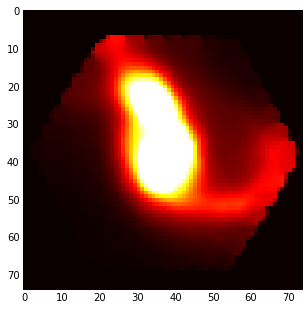

In [3]:
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()
ax.imshow(np.sum(cube,axis=0), vmax=2000, cmap=cm.hot, interpolation='nearest')

<h3>2 - Find emission</h3>

To maximize SNR, build sum from entire cube along wavelength dimension.

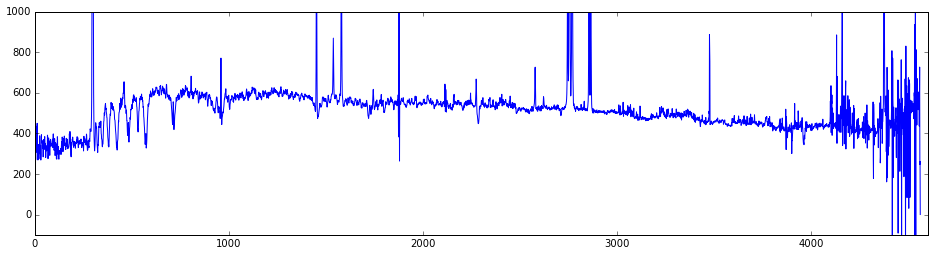

In [4]:
summed = np.sum(cube, axis=2)
summed = np.sum(summed, axis=1)

plt.gcf().set_size_inches(16.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed)

<h3>3 - Mask out emission region </h3>

1 - Build mask that rejects wavelength ranges with emission.

2 - Use mask to build a masked data cube.

In [5]:
mask = cube.copy()
mask.fill(False)
mask[ 240: 600,:,:] = True  # these were determined by examining the plot above with a large
mask[ 670: 730,:,:] = True  # zoom factor. Some interaction is unavoidable here.
mask[ 900:1000,:,:] = True  
mask[1400:1600,:,:] = True  
mask[1870:1900,:,:] = True  
mask[2070:2100,:,:] = True  
mask[2250:2310,:,:] = True  
mask[2560:2590,:,:] = True  
mask[2700:2900,:,:] = True  
mask[3450:3500,:,:] = True  
mask[3800:4000,:,:] = True  
mask[4050:4300,:,:] = True  
mask[4310:4563,:,:] = True  

masked_cube = ma.masked_array(cube, mask=mask)

<h3>4 - Verify that masked data cube is OK </h3>

Again, build sum for entire *masked* cube. Data in masked wavelength ranges should be absent.

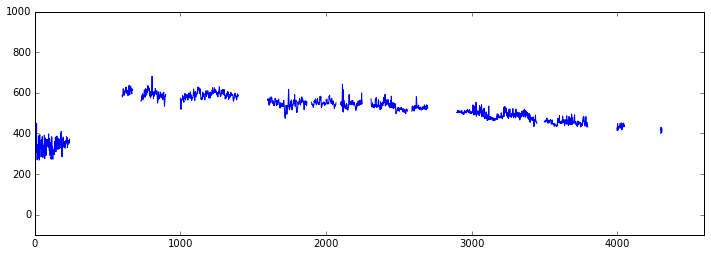

In [6]:
summed_masked = np.sum(masked_cube, axis=2)
summed_masked = np.sum(summed_masked, axis=1)

plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked)

<h3>5 - Build 1-D continuum model by interpolation-smoothing summed masked spectrum </h3>

<h4>Stuck here: scipy interpolation routines do not seem to work well with masked arrays for our specific problem.The problem seems to be that masked arrays are not really masked. The masked data points are not removed from the array, but just assigned a value of zero.</h4>

We want the interpolation functions to fill the masked-out gaps with interpolated data, but they won't ignore the masked data. They just use the zeroed values for these data points, ignoring that they are not "just" zero values, but masked values.

Here is an example:

In [76]:
# set spline nodes 50 spectral pixels apart
nodes = range(1,4563,50)    

# remove nodes that are inside masked regions
indices_bad = np.where(summed_masked == 0.0)[0].tolist()
good_nodes = []
for node in nodes:
    if node not in indices_bad:
        good_nodes.append(node)
good_nodes = np.array(good_nodes)
print(good_nodes)

[   1   51  101  151  201  601  651  751  801  851 1001 1051 1101 1151 1201
 1251 1301 1351 1601 1651 1701 1751 1801 1851 1901 1951 2001 2051 2101 2151
 2201 2351 2401 2451 2501 2551 2601 2651 2901 2951 3001 3051 3101 3151 3201
 3251 3301 3351 3401 3501 3551 3601 3651 3701 3751 4001 4301]


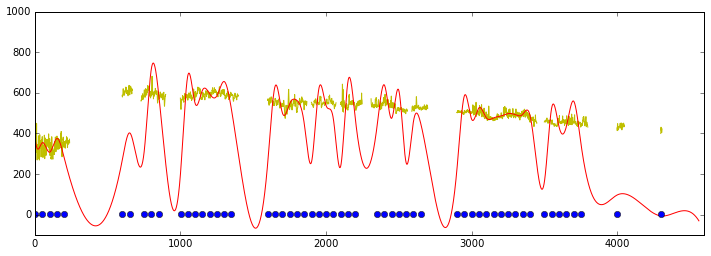

In [77]:
x = np.asarray(range(len(summed_masked)))

continuum = LSQUnivariateSpline(x, summed_masked, good_nodes)(x)

constant = np.ones(shape=good_nodes.shape)
plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked, 'y')
plt.plot(continuum, 'r')
plt.plot(good_nodes, constant, 'bo')

The same behavior is seen with the other interpolators. 

<h4>Stuck here as well: scipy interpolation routines do not seem to like weighted fits where the weights are zeros.</h4>

We can try to use weights in the interpolation function calls. Additionally, or instead, of using a masked array, we can build a weight array that is one where the data is good, and zero where we want to discard data.

Some interpolators do not accept weights. For the ones that do, the result is always the same. They return an array of NaN's. From the documentation in scipy, we can infer that weights are not supposed to be zero. They can be either 1.0, or a value that relates to the inverse errors in the data.

Here is an example:

In [8]:
indices_bad = np.where(summed_masked == 0.0)
weights = np.ones(len(summed_masked))
weights[indices_bad] = 0.0

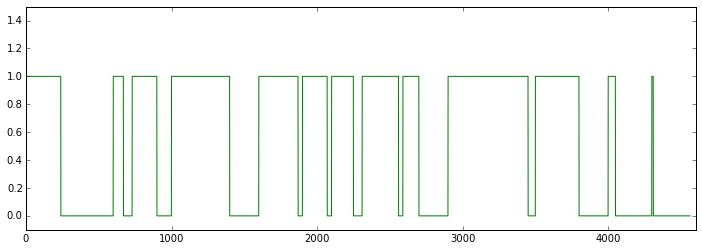

In [9]:
plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-0.1,1.5])
plt.plot(weights, 'g')

Now interpolate as above, but adding the weights array to the mix:

In [10]:
continuum = InterpolatedUnivariateSpline(x, summed_masked, w=weights)(x)

In [11]:
continuum

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

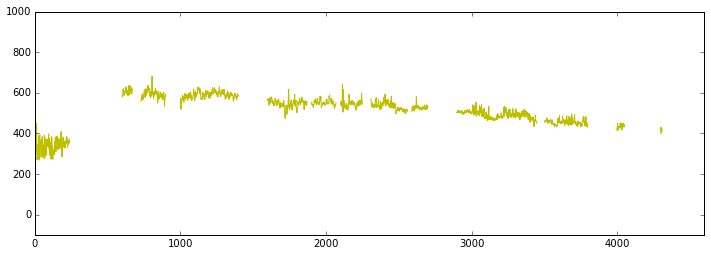

In [12]:
plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed_masked, 'y')
plt.plot(continuum, 'r')

<h4>Doesn't work here either: using weights as above, on a plain, non-masked array, does not solve the problem.</h4>

As a last resort, we can ignore the masked data entirely and use the raw data instead. Maybe masked arrays and weights do not play well together? Note that this defeats the purpose of this exercise, which is to demonstarte the usefullness of masked arrays for interpolation.

Lets repeat the computations but now using the plain cube as input:

In [13]:
summed = np.sum(cube, axis=2)
summed = np.sum(summed, axis=1)

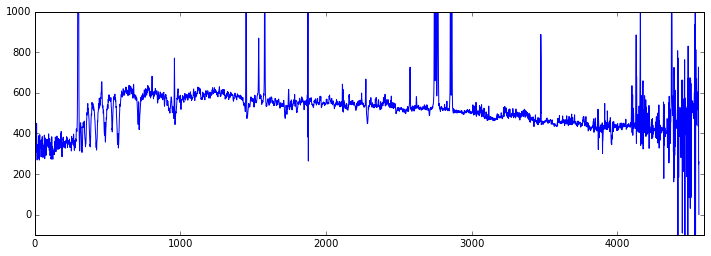

In [14]:
plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed)

In [15]:
continuum = InterpolatedUnivariateSpline(x, summed, w=weights)(x)

Again, we get an array of NaN's:

In [16]:
continuum

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

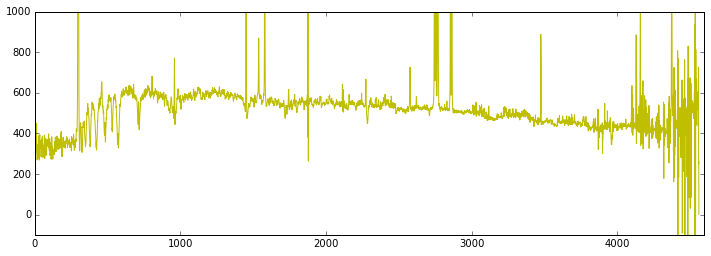

In [17]:
plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed, 'y')
plt.plot(continuum, 'r')